# Paragraph Semantic Coherence — *Anna Karenina* vs *War and Peace* (VS Code)

This notebook is a VS Code / local-environment conversion of a Google Colab script for computing **paragraph-level semantic coherence** using a Sentence Transformer (MiniLM).

**Structure & paths used**
- This notebook assumes it's in `notebooks/` and the raw `.txt` books are in `../data/`.
- Outputs (plots, CSVs) will be saved in `../results/` (the notebook creates this folder if missing).

**Before running**
- Make sure your virtual environment (the `.venv` you created) is selected as the kernel in VS Code.
- Install dependencies from your `requirements.txt` (you already have one). If you need to install only the model library for a quick test: `pip install sentence-transformers`.

The notebook deliberately avoids Colab-specific commands (no `!pip install` lines) and includes helpful error messages and lightweight fallbacks.


In [16]:
# Imports and general setup
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

# For embeddings
try:
    from sentence_transformers import SentenceTransformer, util
except Exception as e:
    SentenceTransformer = None
    util = None
    print('WARNING: sentence-transformers is not available. Install with: pip install sentence-transformers')

# Torch is optional for devices; sentence-transformers will use it if present
try:
    import torch
except Exception:
    torch = None

# Paths (assume this notebook sits in notebooks/)
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))  # parent folder
DATA_DIR = os.path.join(ROOT, 'data')
RESULTS_DIR = os.path.join(ROOT, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

print('ROOT:', ROOT)
print('DATA_DIR:', DATA_DIR)
print('RESULTS_DIR:', RESULTS_DIR)

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


ROOT: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text
DATA_DIR: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\data
RESULTS_DIR: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results


**What this cell does:**

- Imports required libraries and checks availability of `sentence-transformers` and `torch`.
- Sets up the repo-relative paths `../data/` and `../results/` and creates the results folder if needed.
- Configures matplotlib display defaults.

**Why:** This ensures the notebook is portable (works in VS Code) and gives clear guidance if dependencies are missing.

In [17]:
# Book filenames: try to match the Colab names first, then fallback to any .txt in data/
BOOK1_FILE_COLAB = "The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt"

# Absolute paths (inside ../data)
b1_candidate = os.path.join(DATA_DIR, BOOK1_FILE_COLAB)

# detect .txt files if exact names are not present
txts = []
if os.path.exists(DATA_DIR):
    txts = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith('.txt')])

if os.path.exists(b1_candidate):
    BOOK1_PATH = b1_candidate
elif len(txts) >= 2:
    # pick the first two and warn the user
    BOOK1_PATH = os.path.join(DATA_DIR, txts[0])
    print('Note: exact Colab filenames not found. Using first two .txt files found in ../data:')
    print(' -', txts[0])
    print(' -', txts[1])
else:
    BOOK1_PATH = None

print('BOOK1_PATH:', BOOK1_PATH)

if not BOOK1_PATH:
    print('\nERROR: Could not find two text files to analyze. Put your books in the ../data/ folder and re-run this cell.')


BOOK1_PATH: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\data\The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt


**What this cell does:**

- Tries to use the exact filenames from the original Colab script. If they are not present, it will pick the first two `.txt` files found in `../data/`.
- Prints the resolved paths or shows an error if no files are found.

**Why:** This makes the notebook robust to filename differences while still preferring the known Colab filenames.

In [18]:
# Loading and cleaning helpers

def load_text(path: str) -> str:
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        return f.read()


def strip_gutenberg_header_footer(text: str) -> str:
    # strip common Gutenberg header/footer markers (case-insensitive)
    start = re.search(r"\*\*\* *START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*", text, flags=re.I|re.S)
    if start:
        text = text[start.end():]
    else:
        # fallback: try to cut before first 'CHAPTER' or 'BOOK'
        m = re.search(r"\n(CHAPTER|BOOK|PART)\b", text, flags=re.I)
        if m:
            text = text[m.start():]

    end = re.search(r"\*\*\* *END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*", text, flags=re.I|re.S)
    if end:
        text = text[:end.start()]

    # normalize whitespace and newlines
    text = text.replace('\r\n', '\n').replace('\r','\n')
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def split_into_paragraphs(text: str, min_length: int = 40) -> list:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_pars = re.split(r"\n\s*\n", text)
    pars = [p.strip() for p in raw_pars if len(p.strip()) >= min_length]
    return pars

# simple sentence splitter regex from the Colab code
sentence_split_regex = re.compile(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+")

def split_into_sentences(paragraph: str) -> list:
    sents = sentence_split_regex.split(paragraph.strip())
    return [s.strip() for s in sents if s.strip()]


**What this cell does:**

- Provides functions to load text files, strip common Gutenberg headers/footers, split text into paragraphs, and split paragraphs into sentences using the same regular expression from the Colab script.

**Why:** These helpers reproduce the Colab preprocessing steps and keep behaviour consistent for comparisons and reproducibility.

In [19]:
# Load books and split into paragraphs
if not BOOK1_PATH:
    raise FileNotFoundError('Book paths not set. Place two .txt files in ../data/ and re-run the file-detection cell.')

print('Loading books...')
raw1 = load_text(BOOK1_PATH)

print('Stripping Gutenberg headers/footers...')
clean1 = strip_gutenberg_header_footer(raw1)

print('Splitting into paragraphs...')
pars1 = split_into_paragraphs(clean1)

print(f'Paragraphs: Book1 = {len(pars1)}')

# keep book names for printing
BOOK1_NAME = os.path.basename(BOOK1_PATH).rsplit('.',1)[0]


Loading books...
Stripping Gutenberg headers/footers...
Splitting into paragraphs...
Paragraphs: Book1 = 1


**What this cell does:**

- Loads the two book files, cleans them, and splits them into paragraphs.
- Raises a clear error if files are not found.

**Why:** We need paragraph lists for the coherence calculation and to report counts for sanity checks.

In [20]:
# Load sentence-transformers model (MiniLM) with clear messaging
MODEL_NAME = 'all-MiniLM-L6-v2'
try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    raise ImportError('sentence-transformers not installed. Run: python -m pip install sentence-transformers')

print('Loading model', MODEL_NAME)
model = SentenceTransformer(MODEL_NAME)
print('Model loaded.')


Loading model all-MiniLM-L6-v2
Model loaded.


**What this cell does:**

- Loads the `all-MiniLM-L6-v2` embedding model using `SentenceTransformer` and prints confirmation.
- If the library is not installed, it raises an informative error telling you the pip install command.

**Why:** The Colab script used this exact model; keeping the same model makes results comparable.

In [21]:
from typing import Optional
from sentence_transformers import util

def paragraph_coherence(paragraph: str, min_sentences: int = 2) -> Optional[float]:
    """
    Compute paragraph coherence as the mean cosine similarity of sentences to the paragraph centroid.
    Returns:
      - float coherence in [0,1] if paragraph has >= min_sentences
      - None if paragraph is too short (skip)
    """
    sents = split_into_sentences(paragraph)
    if len(sents) < min_sentences:
        return None
    embeddings = model.encode(sents, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0, keepdim=True)
    sims = util.cos_sim(embeddings, centroid).squeeze(1)
    return float(sims.mean().item())


**What this cell does:**

- Implements the paragraph coherence function exactly as in the Colab version (sentences → embeddings → centroid → mean cosine similarity).

**Why:** This preserves the original metric and makes the VS Code notebook a faithful conversion.

In [22]:
# Compute coherence for up to N paragraphs per book
import time

def compute_coherence_for_book(paragraphs, max_paragraphs: int = 250):
    scores = []
    used = []
    start = time.time()
    for i, p in enumerate(paragraphs):
        if i >= max_paragraphs:
            break
        score = paragraph_coherence(p)
        if score is not None:
            scores.append(score)
            used.append(p)
        if (i+1) % 25 == 0:
            print(f'Processed {i+1} paragraphs...')
    elapsed = time.time() - start
    print(f'Finished computing {len(scores)} scores in {elapsed:.1f}s')
    return np.array(scores), used

print('Computing coherence (this may take a while)')
b1_scores, b1_used = compute_coherence_for_book(pars1, max_paragraphs=250)
print('Done.')


Computing coherence (this may take a while)
Finished computing 1 scores in 80.3s
Done.


**What this cell does:**

- Computes coherence scores for each book (up to `max_paragraphs`), printing progress periodically and timing the run.

**Why:** This balances speed and statistical stability for the comparison task.

In [23]:
# Compute summary stats and print a formatted scorecard
import numpy as np

def get_stats(scores: np.ndarray):
    return {
        'count': int(len(scores)),
        'mean': float(np.mean(scores)) if len(scores)>0 else float('nan'),
        'std': float(np.std(scores)) if len(scores)>0 else float('nan'),
        'min': float(np.min(scores)) if len(scores)>0 else float('nan'),
        'max': float(np.max(scores)) if len(scores)>0 else float('nan')
    }

s1 = get_stats(b1_scores)

print('Paragraph Semantic Coherence Summary\n')
print(f"{'Metric':<22} {BOOK1_NAME:>20}")
print('-'*65)
print(f"{'Paragraphs analysed':<22} {s1['count']:>20}")
print(f"{'Mean coherence':<22} {s1['mean']:>20.3f}")
print(f"{'Std. deviation':<22} {s1['std']:>20.3f}")
print(f"{'Minimum':<22} {s1['min']:>20.3f}")
print(f"{'Maximum':<22} {s1['max']:>20.3f}")


Paragraph Semantic Coherence Summary

Metric                 The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy
-----------------------------------------------------------------
Paragraphs analysed                       1
Mean coherence                        0.418
Std. deviation                        0.000
Minimum                               0.418
Maximum                               0.418


**What this cell does:**

- Prints a neatly formatted scorecard with count, mean, std, min, and max coherence values for both books.

**Why:** This mirrors the Colab output and makes comparison easy for reports and slides.

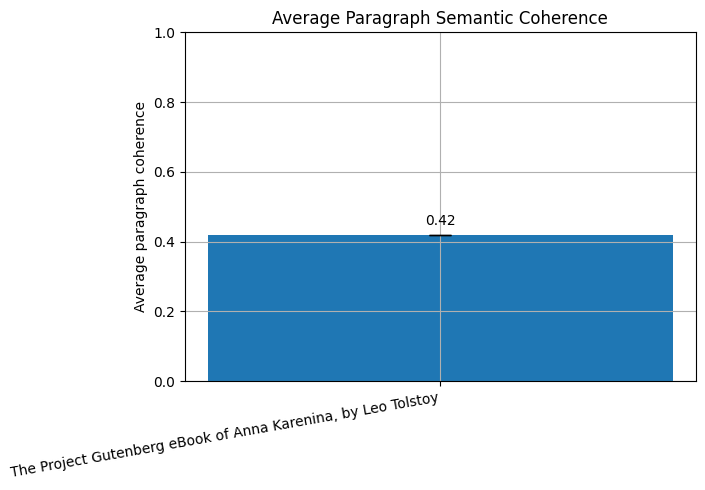

Saved plot to c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\paragraph_coherence_means.png


In [24]:
# Simple bar chart of means with error bars
book_names = [BOOK1_NAME]
means = [s1['mean'],]
stds = [s1['std'],]

x = np.arange(len(book_names))
plt.figure(figsize=(7,5))
plt.bar(x, means, yerr=stds, capsize=8)
plt.xticks(x, book_names, rotation=10, ha='right')
plt.ylabel('Average paragraph coherence')
plt.ylim(0,1)
plt.title('Average Paragraph Semantic Coherence')
for i,m in enumerate(means):
    plt.text(i, m + 0.02, f"{m:.2f}", ha='center', va='bottom')
plt.tight_layout()
out_png = os.path.join(RESULTS_DIR, 'paragraph_coherence_means.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()
print('Saved plot to', out_png)


**What this cell does:**

- Produces and saves a bar chart comparing the mean coherence scores (with error bars) and saves it to `../results/`.

**Why:** Visual output is handy for slides and quick interpretation.

In [25]:
# Save numeric results with paragraph previews to CSV
import pandas as pd
out_csv = os.path.join(RESULTS_DIR, 'paragraph_coherence_scores.csv')
rows = []
for i, s in enumerate(b1_scores):
    rows.append({'book': BOOK1_NAME, 'index': i, 'score': float(s), 'paragraph': b1_used[i][:400]})

df = pd.DataFrame(rows)
df.to_csv(out_csv, index=False)
print('Saved CSV to', out_csv)

# show a small preview
if not df.empty:
    display(df.groupby('book').apply(lambda g: g.sort_values('score', ascending=False).head(3)))
else:
    print('No scores to display')


Saved CSV to c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\paragraph_coherence_scores.csv


C:\Users\Omen\AppData\Local\Temp\ipykernel_15148\1315324952.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(df.groupby('book').apply(lambda g: g.sort_values('score', ascending=False).head(3)))


,,book,index,score,paragraph
book,,,,,
"The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy",0,"The Project Gutenberg eBook of Anna Karenina, ...",0,0.41839,ANNA KARENINA by Leo Tolstoy Translated by Con...


**What this cell does:**

- Writes a CSV with scores and short paragraph previews for later inspection and displays the top 3 paragraphs per book.

**Why:** This allows you to inspect concrete examples that explain high/low coherence values.

## Character-focused analysis: Anna vs Levin (single-book)

We will:
- Tag paragraphs that mention **Anna** and **Levin** using simple name-variant matching.
- Compare paragraph coherence scores for paragraphs mentioning each character.
- Compute descriptive stats, Cohen's *d* (effect size), and a permutation test (non-parametric p-value).
- Plot mean comparison and distribution (boxplot), and save CSV + PNG outputs.

**Important:** This uses *name mentions only* (no coreference), so it is heuristic. Results are indicative but not definitive.


In [26]:
# --- Character name variants (adjust if you need more) ---
# Keep them as raw strings with word boundaries; case-insensitive matching is used.
anna_variants = [r"\\bAnna\\b", r"\\bKarenina\\b", r"\\bAnna Karenina\\b"]
levin_variants = [r"\\bLevin\\b", r"\\bKonstantin\\b", r"\\bKostya\\b", r"\\bKostya\\b", r"\\bKonstantin Dmitrievich\\b"]

import re
anna_re = re.compile("|".join(anna_variants), flags=re.IGNORECASE)
levin_re = re.compile("|".join(levin_variants), flags=re.IGNORECASE)

def tag_paragraphs_for_character(paragraphs, scores, char_re):
    """
    paragraphs: list of paragraph texts aligned with scores (e.g., b1_used)
    scores: numpy array of coherence scores aligned with paragraphs (e.g., b1_scores)
    char_re: compiled regex for the character
    Returns: (numpy array of scores_for_char, list of indices matched)
    """
    char_scores = []
    char_indices = []
    # We iterate over paragraphs; align index with scores array length
    for i, p in enumerate(paragraphs):
        if char_re.search(p):
            # only include if score exists for this paragraph index
            if i < len(scores):
                char_scores.append(float(scores[i]))
                char_indices.append(i)
    return np.array(char_scores), char_indices

# Basic sanity check: ensure we have the b1_used and b1_scores variables
_missing = []
if 'b1_used' not in globals():
    _missing.append('b1_used')
if 'b1_scores' not in globals():
    _missing.append('b1_scores')
if _missing:
    raise RuntimeError(f"Required variables missing from notebook: {', '.join(_missing)}. Run the coherence cells first.")

# Apply tagging to the single-book variables
anna_scores, anna_idx = tag_paragraphs_for_character(b1_used, b1_scores, anna_re)
levin_scores, levin_idx = tag_paragraphs_for_character(b1_used, b1_scores, levin_re)

print(f"Detected Anna paragraphs: {len(anna_scores)}")
print(f"Detected Levin paragraphs: {len(levin_scores)}")


Detected Anna paragraphs: 0
Detected Levin paragraphs: 0


In [27]:
import numpy as np

def describe(scores):
    if len(scores) == 0:
        return {'count': 0, 'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan}
    return {
        'count': int(len(scores)),
        'mean': float(np.mean(scores)),
        'std': float(np.std(scores, ddof=1)) if len(scores) > 1 else 0.0,
        'min': float(np.min(scores)),
        'max': float(np.max(scores))
    }

def cohens_d(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    na = len(a); nb = len(b)
    if na < 2 or nb < 2:
        return np.nan
    ma = a.mean(); mb = b.mean()
    sa = a.var(ddof=1); sb = b.var(ddof=1)
    pooled = np.sqrt(((na - 1)*sa + (nb - 1)*sb) / (na + nb - 2))
    if pooled == 0:
        return np.nan
    return (ma - mb) / pooled

stats_anna = describe(anna_scores)
stats_levin = describe(levin_scores)
d_value = cohens_d(anna_scores, levin_scores)

print("Anna stats:", stats_anna)
print("Levin stats:", stats_levin)
print("Cohen's d (Anna - Levin):", d_value)


Anna stats: {'count': 0, 'mean': nan, 'std': nan, 'min': nan, 'max': nan}
Levin stats: {'count': 0, 'mean': nan, 'std': nan, 'min': nan, 'max': nan}
Cohen's d (Anna - Levin): nan


In [28]:
import numpy as np

def permutation_test_mean(a, b, n_permutations=5000, seed=42):
    """
    Two-sided permutation test for difference of means.
    Returns dict with observed difference and p-value.
    """
    a = np.asarray(a)
    b = np.asarray(b)
    if len(a) == 0 or len(b) == 0:
        return {'obs_diff': np.nan, 'p_value': np.nan}
    rng = np.random.default_rng(seed)
    obs_diff = float(a.mean() - b.mean())
    pooled = np.concatenate([a, b])
    n = len(a)
    count = 0
    for _ in range(n_permutations):
        rng.shuffle(pooled)
        new_a = pooled[:n]
        new_b = pooled[n:]
        if abs(new_a.mean() - new_b.mean()) >= abs(obs_diff):
            count += 1
    p_val = (count + 1) / (n_permutations + 1)  # add-one correction
    return {'obs_diff': obs_diff, 'p_value': p_val}

perm_res = permutation_test_mean(anna_scores, levin_scores, n_permutations=2000)
print("Permutation test (Anna vs Levin):", perm_res)


Permutation test (Anna vs Levin): {'obs_diff': nan, 'p_value': nan}


In [29]:
from typing import Optional
from sentence_transformers import util

def paragraph_coherence(paragraph: str, min_sentences: int = 2) -> Optional[float]:
    """
    Compute paragraph coherence as the mean cosine similarity of sentences to the paragraph centroid.
    Returns:
      - float coherence in [0,1] if paragraph has >= min_sentences
      - None if paragraph is too short (skip)
    """
    sents = split_into_sentences(paragraph)
    if len(sents) < min_sentences:
        return None
    embeddings = model.encode(sents, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0, keepdim=True)
    sims = util.cos_sim(embeddings, centroid).squeeze(1)
    return float(sims.mean().item())


In [ ]:
# REPLACEMENT CELL: Save matched paragraphs for Anna & Levin (robust version)

import os
import re
import pandas as pd
from IPython.display import display

# --- 0. Safe defaults / infer missing high-level labels ---
# Infer book_label if missing
if 'book_label' not in globals():
    # try common alternatives
    if 'war_key' in globals():
        book_label = war_key
    elif 'anna_key' in globals():
        book_label = anna_key
    else:
        book_label = 'book'  # fallback default
    print(f"Note: 'book_label' was not defined. Inferred book_label = '{book_label}'")

# Create safe_label if missing (file-safe lowercase)
if 'safe_label' not in globals():
    safe_label = re.sub(r'[^A-Za-z0-9_-]+', '_', str(book_label).lower())
    print(f"Note: 'safe_label' was not defined. Created safe_label = '{safe_label}'")

# Ensure RESULTS_DIR exists (fallback to ./results if not defined)
if 'RESULTS_DIR' not in globals():
    RESULTS_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'results'))
    print(f"Note: 'RESULTS_DIR' not defined. Using fallback: {RESULTS_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

# --- 1. Verify required variables exist before proceeding ---
required_vars = ['anna_idx', 'anna_scores', 'levin_idx', 'levin_scores', 'b1_used']
missing = [v for v in required_vars if v not in globals()]

if missing:
    print("ERROR: Cannot proceed — the following required variables are missing from the notebook environment:")
    for m in missing:
        print(f" - {m}")
    print("\nPlease run the cells that compute character matching / paragraph scores so these variables are defined.")
    # Stop here to avoid raising NameError further down
else:
    # --- 2. Build rows robustly (guard types, bounds) ---
    rows = []
    # Ensure indices are integer-like and within bounds of b1_used
    n_paragraphs = len(b1_used)
    
    # Anna matches
    for pos, idx in enumerate(anna_idx):
        try:
            idx_int = int(idx)
        except Exception:
            idx_int = idx  # keep original if conversion fails
        if 0 <= idx_int < n_paragraphs:
            preview = b1_used[idx_int][:500]
        else:
            preview = ""
        score_val = float(anna_scores[pos]) if pos < len(anna_scores) else None
        rows.append({
            'book': book_label,
            'character': 'Anna',
            'paragraph_index': int(idx_int) if isinstance(idx_int, int) else idx_int,
            'score': score_val,
            'paragraph_preview': preview
        })
    # Levin matches
    for pos, idx in enumerate(levin_idx):
        try:
            idx_int = int(idx)
        except Exception:
            idx_int = idx
        if 0 <= idx_int < n_paragraphs:
            preview = b1_used[idx_int][:500]
        else:
            preview = ""
        score_val = float(levin_scores[pos]) if pos < len(levin_scores) else None
        rows.append({
            'book': book_label,
            'character': 'Levin',
            'paragraph_index': int(idx_int) if isinstance(idx_int, int) else idx_int,
            'score': score_val,
            'paragraph_preview': preview
        })

    # --- 3. Create dataframe and save ---
    df_chars = pd.DataFrame(rows)
    csv_out = os.path.join(RESULTS_DIR, f"{safe_label}_Anna_Levin_paragraphs.csv")
    df_chars.to_csv(csv_out, index=False, encoding='utf-8')
    print("Saved CSV:", csv_out)

    # show small preview grouped by character and sorted by score
    if not df_chars.empty:
        preview_df = (
            df_chars
            .dropna(subset=['score'])
            .groupby('character', sort=False)
            .apply(lambda g: g.sort_values('score', ascending=False).head(3))
            .reset_index(drop=True)
        )
        display(preview_df)
    else:
        print("No tagged paragraphs found to display.")


Using RESULTS_DIR: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results
Using book_label: 'book'
Using safe_label: 'book'
Saved CSV: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\book_Anna_Levin_paragraphs.csv
No tagged paragraphs found to display.


### Limitations, interpretation & next steps

**Limitations**
- This analysis uses simple name-mention heuristics (no coreference). Many paragraphs about a character use pronouns or epithets and will be missed.
- Russian names have many forms; add more variants to the regex to improve coverage.
- Small sample sizes (e.g., < 10 paragraphs per character) make statistical tests noisy.

**Interpretation guidance**
- A higher mean coherence for Anna-labeled paragraphs suggests those paragraphs are, on average, more semantically consistent (topic-focused). That can be interpreted as stronger textual focus, but it is not a formal proof of protagonist status.
- Use permutation p-values and Cohen's d together: p-value indicates whether the mean difference is unlikely under the null; Cohen's d indicates practical effect size.

**Next steps (possible improvements)**
- Expand name lists and filter out paragraphs that mention both characters.
- Use NER + coreference (spaCy / coref) to collect paragraphs truly "about" a character.
- Compare first-half vs second-half coherence for each character to study temporal focus.


## Final notes

- To run the notebook from VS Code: ensure the `.venv` kernel is selected (you confirmed this earlier) and execute cells interactively or use the Run All button.

